In [27]:
import os
import json
from collections import Counter, defaultdict

def load_labels(folder="./consensus"):
    """Load all label JSONs from a folder, skipping empty or invalid files."""
    data = {}
    for fname in os.listdir(folder):
        if not fname.endswith(".json"):
            continue
        fpath = os.path.join(folder, fname)
        with open(fpath, "r", encoding="utf-8") as f:
            content = f.read().strip()
            if not content:
                print(f"⚠️ Skipping empty file: {fname}")
                continue
            try:
                data[fname] = json.loads(content)
            except json.JSONDecodeError as e:
                print(f"⚠️ Skipping invalid JSON in {fname}: {e}")
                continue
    return data



def overlap(a, b):
    """Return overlap length between two intervals [a_start, a_end], [b_start, b_end]."""
    return max(0, min(a["end"], b["end"]) - max(a["start"], b["start"]))


def is_same(a, b):
    """Check if two intervals are considered 'the same'."""
    len_a = a["end"] - a["start"]
    len_b = b["end"] - b["start"]
    ov = overlap(a, b)
    return ov >= 0.5 * min(len_a, len_b)

from datetime import datetime

def flatten_annotations(data):
    """
    Flatten Label Studio timeseries JSONs into list of
    {start, end, choices, annotator} entries.
    Converts ISO time strings to numeric timestamps for overlap math.
    """
    all_entries = []

    def parse_time(ts):
        # Converts e.g. "2023-01-10T10:15:00.000Z" → POSIX timestamp (float seconds)
        try:
            return datetime.fromisoformat(ts.replace("Z", "+00:00")).timestamp()
        except Exception:
            return None

    for annotator, tasks in data.items():
        if not isinstance(tasks, list):
            print(f"⚠️ Unexpected top-level format in {annotator}, skipping.")
            continue

        for task in tasks:
            for ann in task.get("annotations", []):
                user = ann.get("completed_by", annotator)
                for r in ann.get("result", []):
                    v = r.get("value", {})
                    start = parse_time(v.get("start"))
                    end = parse_time(v.get("end"))
                    choices = v.get("timeserieslabels")

                    if start is None or end is None or not choices:
                        print(f"⚠️ Skipping malformed entry in {annotator}: {v}")
                        continue

                    all_entries.append({
                        "annotator": str(user),
                        "start": start,
                        "end": end,
                        "choices": choices
                    })

    print(f"✅ Flattened {len(all_entries)} total label intervals from {len(data)} files.")
    return all_entries


def compute_consensus(all_entries):
    """Compute consensus per overlapping group using majority vote."""
    consensus = []
    used = set()
    for i, a in enumerate(all_entries):
        if i in used:
            continue
        group = [a]
        used.add(i)
        for j, b in enumerate(all_entries):
            if j not in used and is_same(a, b):
                group.append(b)
                used.add(j)
        # majority voting for choices
        all_choices = [c for g in group for c in g["choices"]]
        maj = [k for k, v in Counter(all_choices).items() if v == max(Counter(all_choices).values())]
        consensus.append({
            "start": min(g["start"] for g in group),
            "end": max(g["end"] for g in group),
            "choices": maj
        })
    return consensus


def evaluate_accuracy(all_entries, consensus):
    """Compare each annotator to consensus."""
    stats = defaultdict(lambda: {"tp": 0, "fp": 0, "fn": 0})
    for entry in all_entries:
        ann = entry["annotator"]
        matched = False
        for c in consensus:
            if is_same(entry, c):
                if any(ch in c["choices"] for ch in entry["choices"]):
                    stats[ann]["tp"] += 1
                else:
                    stats[ann]["fp"] += 1
                matched = True
                break
        if not matched:
            stats[ann]["fn"] += 1
    # compute accuracy
    for ann, s in stats.items():
        denom = s["tp"] + s["fp"] + s["fn"]
        s["accuracy"] = s["tp"] / denom if denom else 0
    return stats


if __name__ == "__main__":
    data = load_labels("./flags/bullflagdetector/consensus")
    entries = flatten_annotations(data)
    consensus = compute_consensus(entries)
    stats = evaluate_accuracy(entries, consensus)

    print("=== Overlap Statistics ===")

    from collections import defaultdict

    overlaps_global = []
    overlaps_per_label = defaultdict(list)

    for i, a in enumerate(entries):
        for j, b in enumerate(entries):
            if i >= j:
                continue
            ov = overlap(a, b)
            if ov <= 0:
                continue

            min_len = min(a["end"] - a["start"], b["end"] - b["start"])
            percent = 100 * ov / min_len

            # Add to global list
            overlaps_global.append(percent)

            # Add to per-label lists — only for shared labels
            common_labels = set(a["choices"]) & set(b["choices"])
            for lbl in common_labels:
                overlaps_per_label[lbl].append(percent)

    # === Global statistics ===
    if overlaps_global:
        avg_overlap = sum(overlaps_global) / len(overlaps_global)
        print(f"Average overlap (all labels): {avg_overlap:.2f}%")
        print(f"Max overlap: {max(overlaps_global):.2f}%")
        print(f"Overlapping pairs: {len(overlaps_global)}")
    else:
        print("No overlaps found.")

    # === Per-label statistics ===
    print("\n=== Average overlap per label ===")
    if overlaps_per_label:
        for lbl, vals in sorted(overlaps_per_label.items()):
            avg_lbl = sum(vals) / len(vals)
            print(f"{lbl:20s}  {avg_lbl:6.2f}%  ({len(vals)} pairs)")
    else:
        print("No label overlaps found.")

⚠️ Skipping empty file: u4duy6.json
⚠️ Unexpected top-level format in DO1H50.json, skipping.
⚠️ Unexpected top-level format in JRG6JB.json, skipping.
⚠️ Unexpected top-level format in VWXUD6.json, skipping.
✅ Flattened 319 total label intervals from 19 files.
=== Overlap Statistics ===
Average overlap (all labels): 93.66%
Max overlap: 100.00%
Overlapping pairs: 553

=== Average overlap per label ===
Bearish Normal         96.14%  (30 pairs)
Bearish Pennant       100.00%  (1 pairs)
Bearish Wedge         100.00%  (1 pairs)
Bullish Normal         97.23%  (143 pairs)
Bullish Pennant       100.00%  (4 pairs)
Bullish Wedge          98.83%  (10 pairs)


In [85]:
import os
import json
import pandas as pd
from dateutil import parser as date_parser

ROOT = "./flags/bullflagdetector"

def to_ms(val):
    """Robustly converts timestamps to Unix milliseconds (int64)."""
    if val is None or val == "":
        return None
    if isinstance(val, (int, float)):
        return int(val)
    if isinstance(val, str):
        if val.isdigit():
            return int(val)
        try:
            dt = date_parser.parse(val)
            return int(dt.timestamp() * 1000)
        except Exception:
            return None
    return None

def load_all_labels(root_path):
    all_segments = []
    
    # 1. Identify valid folders (skipping consensus/sample)
    folders = [f for f in os.listdir(root_path) 
               if os.path.isdir(os.path.join(root_path, f)) 
               and f.lower() not in ("consensus", "sample")]
    
    print(f"🚀 Processing {len(folders)} student folders for 'timeserieslabels'...\n")

    for folder in folders:
        folder_path = os.path.join(root_path, folder)
        json_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.json')]
        
        for jf in json_files:
            file_path = os.path.join(folder_path, jf)
            
            try:
                with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                    data = json.load(f)
                
                # Standardize data to a list of tasks
                if isinstance(data, dict):
                    data = [data]
                
                for task in data:
                    # --- FORMAT A: Standard Label Studio (annotations -> result -> value) ---
                    if 'annotations' in task:
                        # Extract CSV name
                        csv_name = task.get('data', {}).get('csv') or \
                                   task.get('file_upload') or \
                                   task.get('csv') or \
                                   "unknown_file.csv"
                        csv_name = os.path.basename(csv_name)

                        for ann in task.get('annotations', []):
                            for res in ann.get('result', []):
                                val = res.get('value', {})
                                start_raw = val.get('start')
                                end_raw = val.get('end')
                                
                                # STRICTLY LOOK FOR 'timeserieslabels'
                                # Label Studio returns a list, e.g., ["BearFlag"]
                                label_list = val.get('timeserieslabels')
                                
                                if label_list and isinstance(label_list, list) and len(label_list) > 0:
                                    label_tag = label_list[0]
                                else:
                                    # If key is missing, mark as Unknown so we can debug
                                    label_tag = "Unknown" 

                                if start_raw is not None and end_raw is not None:
                                    all_segments.append({
                                        'annotator': folder,
                                        'json_file': jf,
                                        'csv_file': csv_name,
                                        'start_raw': start_raw,
                                        'start_ms': to_ms(start_raw),
                                        'end_ms': to_ms(end_raw),
                                        'label': label_tag
                                    })

                    # --- FORMAT B: Simple Structure (used by TYEGJ8, VWXUD6) ---
                    elif 'label' in task and isinstance(task['label'], list):
                        csv_name = os.path.basename(task.get('csv', 'unknown_file.csv'))
                        
                        for lbl in task['label']:
                            start_raw = lbl.get('start')
                            end_raw = lbl.get('end')
                            
                            # STRICTLY LOOK FOR 'timeserieslabels' HERE TOO
                            label_list = lbl.get('timeserieslabels')
                            
                            if label_list and isinstance(label_list, list) and len(label_list) > 0:
                                label_tag = label_list[0]
                            else:
                                # Fallback: sometimes these custom formats store label directly as string?
                                # If you see "Unknown" for these folders, we can inspect 'lbl' keys.
                                label_tag = "Unknown"

                            if start_raw is not None:
                                all_segments.append({
                                    'annotator': folder,
                                    'json_file': jf,
                                    'csv_file': csv_name,
                                    'start_raw': start_raw,
                                    'start_ms': to_ms(start_raw),
                                    'end_ms': to_ms(end_raw),
                                    'label': label_tag
                                })

            except Exception as e:
                print(f"❌ Error reading {folder}/{jf}: {e}")

    df = pd.DataFrame(all_segments)
    return df

# --- EXECUTE ---
df = load_all_labels(ROOT)

if not df.empty:
    print("-" * 50)
    print(f"✅ Loaded {len(df)} segments.")
    print("-" * 50)
    
    # Check the labels now
    print("\n📊 Label Counts (Should show Bear/Bull variations):")
    print(df['label'].value_counts())
    
    # Check if any are still stuck as "Unknown"
    if 'Unknown' in df['label'].values:
        print("\n⚠️ Warning: Some segments have 'Unknown' labels. Checking source...")
        print(df[df['label'] == 'Unknown'][['annotator', 'json_file']].head())
else:
    print("No segments found.")

🚀 Processing 21 student folders for 'timeserieslabels'...

--------------------------------------------------
✅ Loaded 1327 segments.
--------------------------------------------------

📊 Label Counts (Should show Bear/Bull variations):
label
Bearish Normal     354
Bullish Normal     347
Bullish Wedge      193
Bearish Wedge      172
Bullish Pennant    156
Bearish Pennant    105
Name: count, dtype: int64


In [86]:
df.head()

,annotator,json_file,csv_file,start_raw,start_ms,end_ms,label
0,AS76HW,labels.json,8e2ef3a4-XAU_1h_data_limited.csv,2006-06-05 01:00,1149462000000,1150200000000,Bearish Normal
1,AS76HW,labels.json,839c2e31-XAU_1m_data_limited.csv,2005-02-11 12:41,1108122060000,1110573180000,Bullish Normal
2,AS76HW,labels.json,839c2e31-XAU_1m_data_limited.csv,2005-01-03 01:07,1104710820000,1107916680000,Bearish Wedge
3,AS76HW,labels.json,839c2e31-XAU_1m_data_limited.csv,2005-04-19 16:01,1113919260000,1114006260000,Bullish Normal
4,AS76HW,labels.json,839c2e31-XAU_1m_data_limited.csv,2009-01-20 08:53,1232437980000,1232733420000,Bullish Pennant


In [87]:
import os
import pandas as pd
import uuid

# --- CONFIGURATION ---
ROOT_DIR = "./flags/bullflagdetector"

def find_csv_in_folder(target_folder, filename_from_json):
    """
    Searches for a CSV within a specific student folder.
    Handles 'Smart Matching' to ignore Label Studio UUID prefixes.
    """
    # 1. Try exact match first
    exact_path = os.path.join(target_folder, filename_from_json)
    if os.path.exists(exact_path):
        return exact_path

    # 2. recursive search in student folder (in case of subdirs like 'upload/')
    # AND fuzzy match (ignoring UUID prefix)
    clean_target_name = filename_from_json
    # If the json name has a UUID prefix like "abc12345-file.csv", try to strip it
    if '-' in clean_target_name and clean_target_name[8] == '-': # Simple heuristic for UUID
        clean_target_name = clean_target_name.split('-', 1)[1]

    for root, dirs, files in os.walk(target_folder):
        for f in files:
            # Case A: Exact filename match in subdirectory
            if f == filename_from_json:
                return os.path.join(root, f)
            
            # Case B: The file on disk is "data.csv" but JSON asks for "12345-data.csv"
            if filename_from_json.endswith(f) and len(f) > 4:
                return os.path.join(root, f)

            # Case C: The file on disk has a prefix, or JSON has a prefix (Flexible endswith)
            # This handles: JSON="uuid-data.csv" vs Disk="data.csv"
            if f.endswith(clean_target_name) or clean_target_name.endswith(f):
                 return os.path.join(root, f)
                 
    return None

def build_timeseries_df_local(metadata_df, root_dir):
    all_segments_data = []
    
    # Group by Annotator (Folder) so we look for CSVs in the right place
    grouped = metadata_df.groupby('annotator')
    
    print(f"🚀 Processing {len(grouped)} folders...\n")

    for annotator, group in grouped:
        student_folder = os.path.join(root_dir, annotator)
        
        # Get unique CSVs this specific student used
        student_csvs = group['csv_file'].unique()
        
        print(f"📂 {annotator}")
        
        for csv_name in student_csvs:
            # Locate CSV *specifically* in this student's folder
            csv_path = find_csv_in_folder(student_folder, csv_name)
            
            if not csv_path:
                count = len(group[group['csv_file'] == csv_name])
                print(f"   ❌ Missing CSV: '{csv_name}' (needed for {count} labels)")
                continue

            try:
                # Load CSV
                df_raw = pd.read_csv(csv_path, sep=None, engine='python')
                
                # Standardize Time Column
                time_col = [c for c in df_raw.columns if 'time' in c.lower()]
                time_col = time_col[0] if time_col else df_raw.columns[0]
                
                # Robust Time Conversion (to match JSON ms)
                try:
                    df_raw['_ts_ms'] = pd.to_numeric(df_raw[time_col])
                    if df_raw['_ts_ms'].mean() < 2e10: # If seconds, convert to ms
                        df_raw['_ts_ms'] = df_raw['_ts_ms'] * 1000
                except:
                    df_raw['_ts_ms'] = pd.to_datetime(df_raw[time_col], utc=True).astype('int64') // 10**6

                # Extract Segments for this specific CSV
                # Filter the group to only rows using this specific CSV
                csv_labels = group[group['csv_file'] == csv_name]
                
                extracted_count = 0
                for _, row in csv_labels.iterrows():
                    start = row['start_ms']
                    end = row['end_ms']
                    
                    # Slice
                    mask = (df_raw['_ts_ms'] >= start) & (df_raw['_ts_ms'] <= end)
                    segment_slice = df_raw[mask].copy()
                    
                    if not segment_slice.empty:
                        segment_slice['segment_id'] = str(uuid.uuid4())
                        segment_slice['label'] = row['label']
                        segment_slice['annotator'] = annotator
                        segment_slice['original_csv'] = csv_name # useful for debug
                        
                        # Normalize columns
                        segment_slice.rename(columns={time_col: 'timestamp'}, inplace=True)
                        segment_slice.columns = [c.lower() for c in segment_slice.columns]
                        
                        all_segments_data.append(segment_slice)
                        extracted_count += 1
                
                print(f"   ✅ Loaded '{csv_name}' -> {extracted_count} segments")

            except Exception as e:
                print(f"   ⚠️ Error reading '{csv_name}': {e}")
        
        # visual separator between students
        print("-" * 40)

    # Compile Final DataFrame
    if all_segments_data:
        final_df = pd.concat(all_segments_data, ignore_index=True)
        print(f"\n🎉 DONE! Extracted {len(final_df)} rows across {final_df['segment_id'].nunique()} unique segments.")
        return final_df
    else:
        print("\n❌ No data extracted.")
        return pd.DataFrame()

# --- EXECUTE ---
# Pass the metadata df from the previous step (load_all_labels)
df_timeseries = build_timeseries_df_local(df, ROOT)

🚀 Processing 18 folders...

📂 AS76HW
   ✅ Loaded '8e2ef3a4-XAU_1h_data_limited.csv' -> 1 segments
   ✅ Loaded '839c2e31-XAU_1m_data_limited.csv' -> 13 segments
   ✅ Loaded '92645c79-XAU_5m_data_limited.csv' -> 10 segments
   ✅ Loaded '0d8ac0b8-XAU_15m_data_limited.csv' -> 16 segments
   ✅ Loaded 'ef46c381-XAU_30m_data_limited.csv' -> 18 segments
----------------------------------------
📂 AY1PC8
   ✅ Loaded '351f4d2a-EURUSD_1H_005.csv' -> 4 segments
   ✅ Loaded '7175fb3f-EURUSD_1min_001.csv' -> 73 segments
----------------------------------------
📂 DMQSIV
   ❌ Missing CSV: '4e85a92d-XAU_30min_001_converted.csv' (needed for 36 labels)
   ❌ Missing CSV: '7623a35c-EURUSD_15min_001_converted_fixed.csv' (needed for 104 labels)
----------------------------------------
📂 DO1H50
   ✅ Loaded '5aabf4f5-EURUSD_1hour_001.csv' -> 52 segments
   ✅ Loaded 'fe98ab23-EURUSD_1minute_001.csv' -> 52 segments
----------------------------------------
📂 GFTYRV
   ✅ Loaded 'e2ab0dd4-GSPC_2025-09-25_to_2025-09-

In [88]:
df_timeseries.head()

,timestamp,open,high,low,close,_ts_ms,segment_id,label,annotator,original_csv,volume
0,2006-06-05 01:00,638.5,640.5,638.2,640.0,1149469200000,099b598f-3b7d-4cfd-b0b4-5a0dec45deb2,Bearish Normal,AS76HW,8e2ef3a4-XAU_1h_data_limited.csv,NaN
1,2006-06-05 02:00,639.7,644.6,639.7,642.0,1149472800000,099b598f-3b7d-4cfd-b0b4-5a0dec45deb2,Bearish Normal,AS76HW,8e2ef3a4-XAU_1h_data_limited.csv,NaN
2,2006-06-05 03:00,641.6,643.5,641.5,642.7,1149476400000,099b598f-3b7d-4cfd-b0b4-5a0dec45deb2,Bearish Normal,AS76HW,8e2ef3a4-XAU_1h_data_limited.csv,NaN
3,2006-06-05 04:00,642.6,642.7,640.2,640.7,1149480000000,099b598f-3b7d-4cfd-b0b4-5a0dec45deb2,Bearish Normal,AS76HW,8e2ef3a4-XAU_1h_data_limited.csv,NaN
4,2006-06-05 05:00,641.0,642.2,640.2,640.5,1149483600000,099b598f-3b7d-4cfd-b0b4-5a0dec45deb2,Bearish Normal,AS76HW,8e2ef3a4-XAU_1h_data_limited.csv,NaN


Displaying 4 examples for each of the 6 labels...


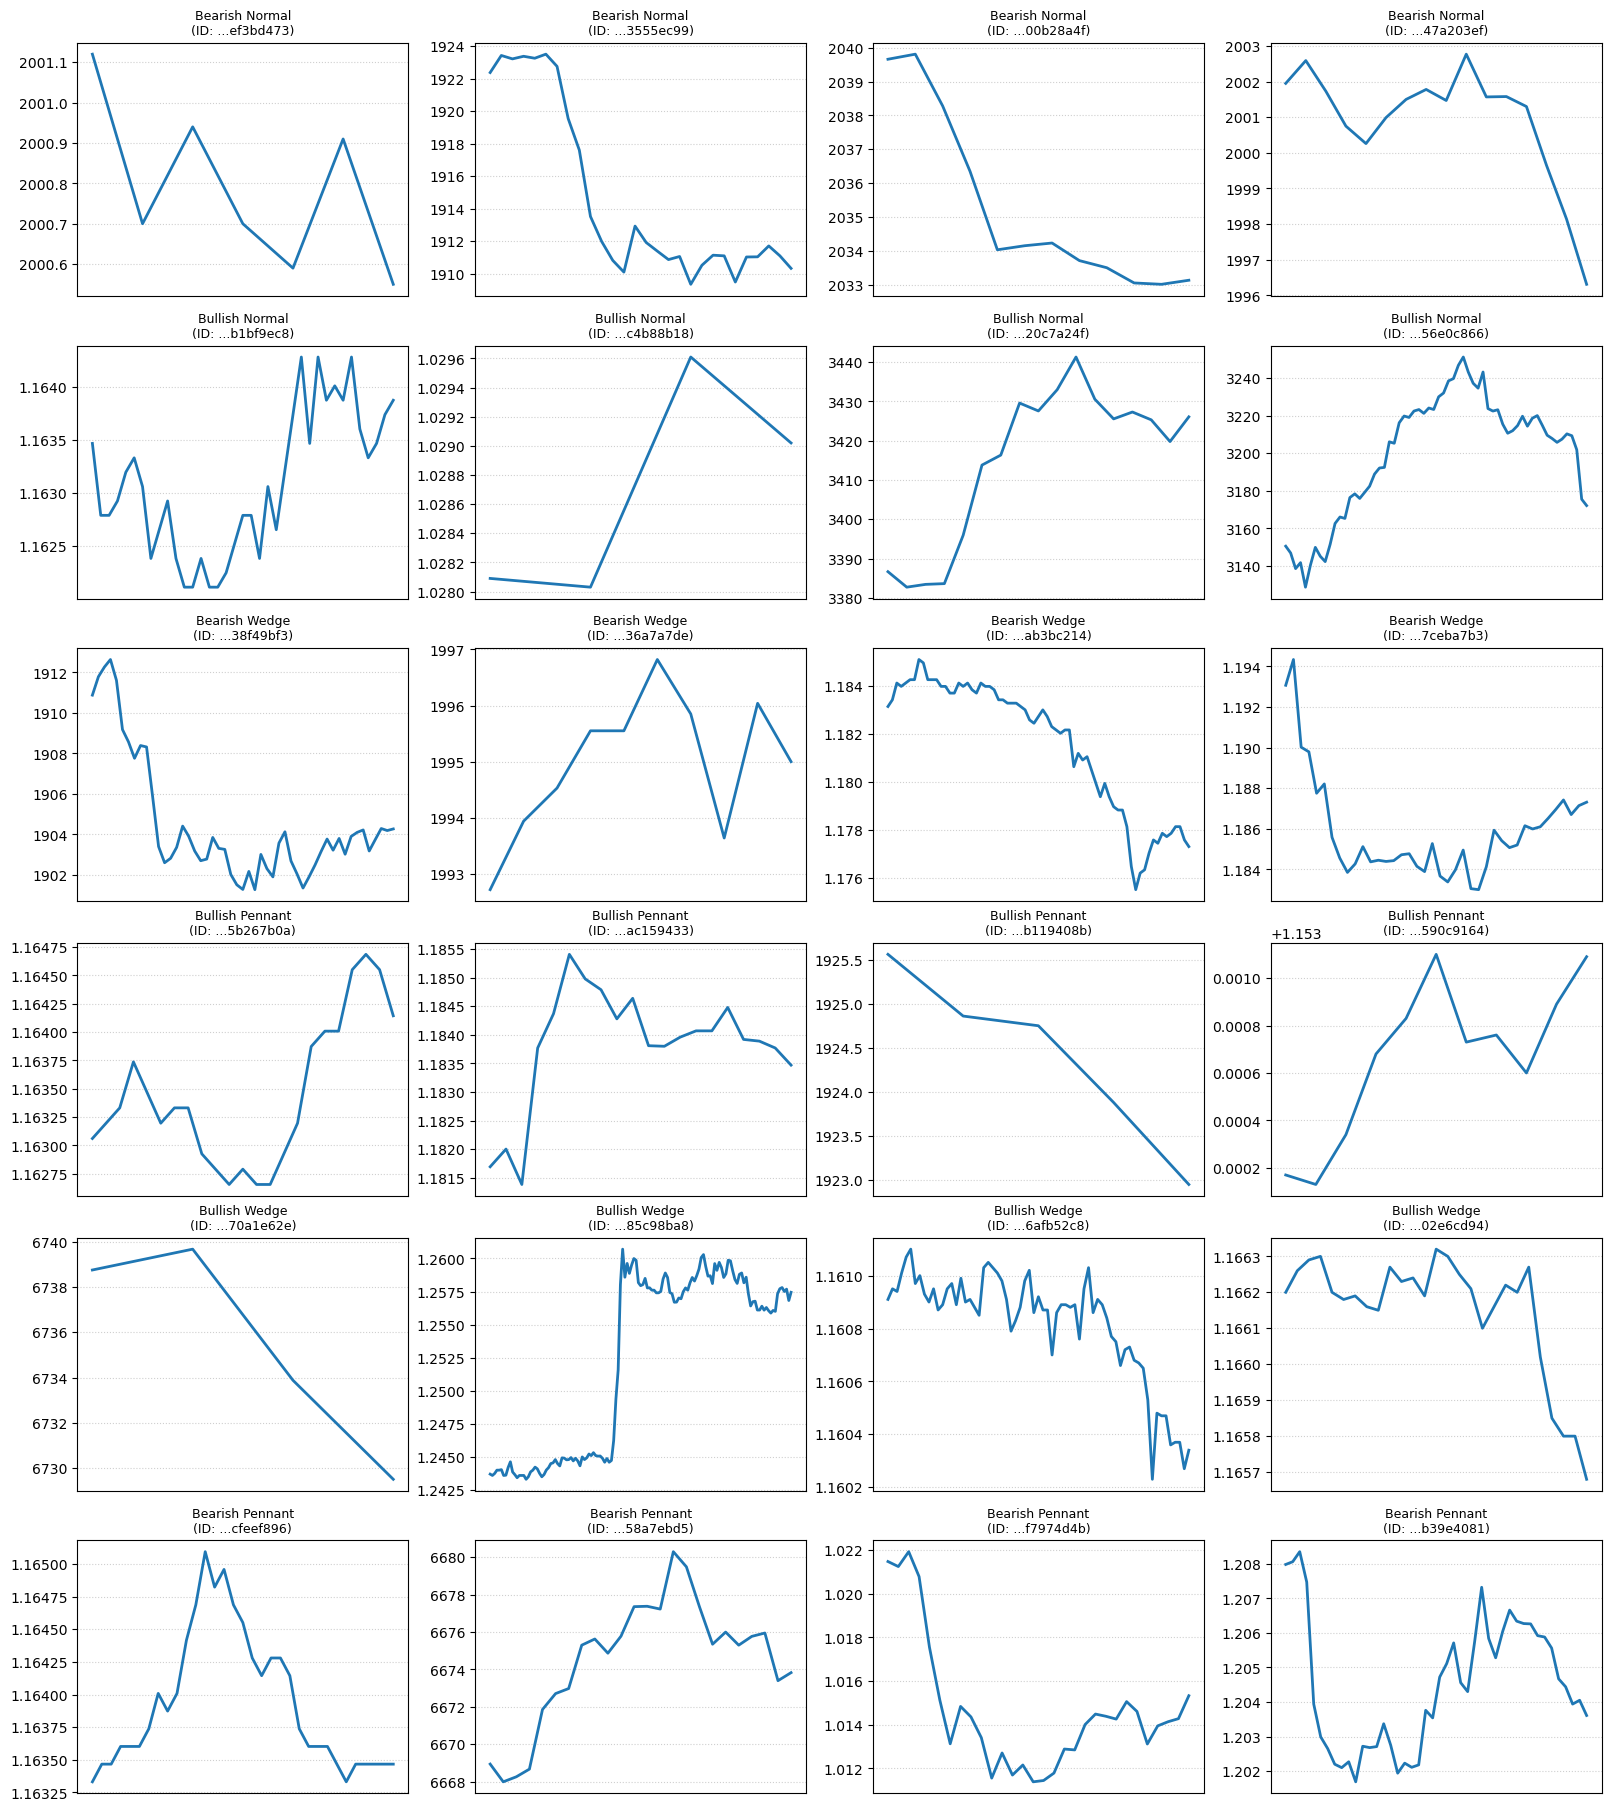

In [89]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# # 1. Load data if not already in memory
# if 'df_timeseries' not in locals():
#     try:
#         df_timeseries = pd.read_csv("all_labeled_timeseries_union.csv")
#     except FileNotFoundError:
#         print("Dataframe not found. Please run the extraction code first.")

# 2. Settings
examples_per_label = 4  # How many charts to show per label
unique_labels = df_timeseries['label'].unique()
cols_to_plot = 'close'  # Assuming 'close' column exists; change if needed

# 3. Setup Plot
fig, axes = plt.subplots(nrows=len(unique_labels), ncols=examples_per_label, 
                         figsize=(16, 3 * len(unique_labels)), constrained_layout=True)

# 4. Loop through each label and plot examples
for i, label in enumerate(unique_labels):
    # Get all unique segment IDs for this specific label
    segment_ids = df_timeseries[df_timeseries['label'] == label]['segment_id'].unique()
    
    # Pick random examples (or use [:examples_per_label] for the first ones)
    chosen_ids = random.sample(list(segment_ids), min(len(segment_ids), examples_per_label))
    
    for j in range(examples_per_label):
        # Handle indexing for 1D vs 2D axes array
        ax = axes[i, j] if len(unique_labels) > 1 else axes[j]
        
        if j < len(chosen_ids):
            seg_id = chosen_ids[j]
            data = df_timeseries[df_timeseries['segment_id'] == seg_id].sort_values('timestamp')
            
            # Plot the data
            ax.plot(data.reset_index(drop=True)[cols_to_plot], color='#1f77b4', linewidth=2)
            
            # Styling
            ax.set_title(f"{label}\n(ID: ...{str(seg_id)[-8:]})", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            ax.set_xticks([]) # Hide x-axis ticks for cleaner look
        else:
            ax.axis('off') # Hide unused subplots if not enough examples

print(f"Displaying {examples_per_label} examples for each of the {len(unique_labels)} labels...")
plt.show()

In [91]:
from sklearn.model_selection import train_test_split

# 1. Get unique segments and their labels for splitting
segment_metadata = df_timeseries.drop_duplicates(subset=['segment_id'])[['segment_id', 'label']]

# 2. Perform Stratified Split on the IDs
train_ids, test_ids = train_test_split(
    segment_metadata['segment_id'], 
    test_size=0.30, 
    random_state=42, 
    stratify=segment_metadata['label']
)

# 3. Create the actual DataFrames
train_df = df_timeseries[df_timeseries['segment_id'].isin(train_ids)].copy()
test_df = df_timeseries[df_timeseries['segment_id'].isin(test_ids)].copy()

# 4. Verification (Counting Unique Flags, NOT Rows)
print(f"Total Segments: {len(segment_metadata)}")
print(f"Train Segments: {len(train_ids)} ({len(train_ids)/len(segment_metadata):.1%})")
print(f"Test Segments:  {len(test_ids)} ({len(test_ids)/len(segment_metadata):.1%})")

print("\n--- Train Distribution (Number of Flags) ---")
# Drop duplicates to count 1 flag as 1 item, regardless of how long it is
print(train_df.drop_duplicates('segment_id')['label'].value_counts())

print("\n--- Test Distribution (Number of Flags) ---")
print(test_df.drop_duplicates('segment_id')['label'].value_counts())

Total Segments: 935
Train Segments: 654 (69.9%)
Test Segments:  281 (30.1%)

--- Train Distribution (Number of Flags) ---
label
Bearish Normal     195
Bullish Normal     190
Bullish Wedge       76
Bearish Wedge       74
Bullish Pennant     69
Bearish Pennant     50
Name: count, dtype: int64

--- Test Distribution (Number of Flags) ---
label
Bearish Normal     84
Bullish Normal     82
Bearish Wedge      32
Bullish Wedge      32
Bullish Pennant    30
Bearish Pennant    21
Name: count, dtype: int64


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence

# --- 1. PREPARE ONE BATCH OF DATA ---

# Settings
BATCH_SIZE = 16
HIDDEN_SIZE = 12
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Select 16 random unique segment IDs from the training set
sample_ids = train_df['segment_id'].drop_duplicates().sample(BATCH_SIZE).values

# Dictionary to map text labels to integers (0, 1, 2...)
unique_labels = train_df['label'].unique()
label_map = {label: i for i, label in enumerate(unique_labels)}

sequences = []
labels = []

for seg_id in sample_ids:
    # Get data for this segment
    seg_data = train_df[train_df['segment_id'] == seg_id].sort_values('timestamp')
    prices = seg_data['close'].values.astype(np.float32)
    
    # CRITICAL: Normalize each sequence independently (Z-score) 
    # LSTMs fail if you mix raw prices like 150.00 (AAPL) and 1.05 (EURUSD)
    prices = (prices - prices.mean()) / (prices.std() + 1e-6)
    
    # Convert to tensor [seq_len, 1]
    sequences.append(torch.tensor(prices).unsqueeze(1))
    
    # Get label
    label_str = seg_data['label'].iloc[0]
    labels.append(label_map[label_str])

# Pad sequences to the length of the longest one in the batch
# Shape becomes: [Batch, Max_Seq_Len, Features]
X_batch = pad_sequence(sequences, batch_first=True).to(DEVICE)
y_batch = torch.tensor(labels).long().to(DEVICE)

print(f"Batch Shape: {X_batch.shape}")  # e.g., [16, 96, 1]
print(f"Device: {DEVICE}")

# --- 2. DEFINE TINY LSTM ---

class TinyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TinyLSTM, self).__init__()
        # Small LSTM: input=1 (close price), hidden=4
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # Linear layer maps the 12 hidden neurons to the class probabilities
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x shape: [batch, seq, feature]
        
        # Run LSTM
        # out: containing output features (h_t) from the last layer of the LSTM for each t
        # (h_n, c_n): containing the final hidden state for each element in the batch
        out, (h_n, c_n) = self.lstm(x)
        
        # We only care about the LAST hidden state (the summary of the whole pattern)
        # h_n shape: [1, batch, hidden_size] -> squeeze to [batch, hidden_size]
        last_hidden = h_n[-1] 
        
        # Classification
        logits = self.fc(last_hidden)
        return logits

# Initialize
model = TinyLSTM(input_size=1, hidden_size=HIDDEN_SIZE, num_classes=len(unique_labels)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# --- 3. TRAIN LOOP (Overfitting one batch) ---

print("\nStarting Training on Single Batch...")
model.train()

for epoch in range(1, 2001):
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_batch)
    loss = criterion(outputs, y_batch)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Check accuracy
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_batch).sum().item()
    acc = correct / BATCH_SIZE
    
    # Logging
    if epoch % 100 == 0 or acc == 1.0:
        print(f"\rEpoch {epoch:4d} | Loss: {loss.item():.4f} | Accuracy: {acc:.0%} ({correct}/{BATCH_SIZE})")
    
    # Early stopping condition
    if acc == 1.0:
        print(f"\n\n✅ Success! Reached 100% accuracy at epoch {epoch}.")
        break

if acc < 1.0:
    print(f"\n\n⚠️ Stopped at 2000 epochs. Final Accuracy: {acc:.0%}")

Batch Shape: torch.Size([16, 96, 1])
Device: cuda

Starting Training on Single Batch...
Epoch  100 | Loss: 1.2611 | Accuracy: 44% (7/16)
Epoch  200 | Loss: 1.1556 | Accuracy: 44% (7/16)
Epoch  300 | Loss: 1.1522 | Accuracy: 44% (7/16)
Epoch  400 | Loss: 1.1831 | Accuracy: 50% (8/16)
Epoch  500 | Loss: 0.8347 | Accuracy: 56% (9/16)
Epoch  600 | Loss: 0.8689 | Accuracy: 56% (9/16)
Epoch  700 | Loss: 0.8258 | Accuracy: 56% (9/16)
Epoch  800 | Loss: 0.7586 | Accuracy: 69% (11/16)
Epoch  876 | Loss: 0.3313 | Accuracy: 100% (16/16)


✅ Success! Reached 100% accuracy at epoch 876.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Configuration
BATCH_SIZE = 16
HIDDEN_SIZE = 64     # "Big" relative to 4. Standard for time series.
NUM_LAYERS = 4       # Stacking LSTMs helps learn higher-level abstractions
DROPOUT = 0.2        # Essential to reduce overfitting on small datasets
EPOCHS = 500          # Enough to converge
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- CUSTOM DATASET CLASS ---
class TimeSeriesDataset(Dataset):
    def __init__(self, df, label_encoder=None):
        self.segments = []
        self.labels = []
        
        # Group by segment_id to reconstruct the sequences
        # We assume df is already sorted by timestamp per segment
        grouped = df.groupby('segment_id')
        
        for _, group in grouped:
            # Feature: Close price
            prices = group['close'].values.astype(np.float32)
            
            # Normalize per sequence (Z-score) to make patterns scale-invariant
            # This is critical so the model sees the *shape*, not the price level ($10 vs $1000)
            if len(prices) > 1 and prices.std() > 0:
                prices = (prices - prices.mean()) / prices.std()
            else:
                prices = (prices - prices.mean()) # Fallback if flat
                
            self.segments.append(torch.tensor(prices).unsqueeze(1)) # [Seq_Len, 1]
            
            # Label
            label_str = group['label'].iloc[0]
            self.labels.append(label_str)
            
        # Encode labels to integers
        if label_encoder is None:
            self.le = LabelEncoder()
            self.encoded_labels = self.le.fit_transform(self.labels)
        else:
            self.le = label_encoder
            self.encoded_labels = self.le.transform(self.labels)
            
    def __len__(self):
        return len(self.segments)
    
    def __getitem__(self, idx):
        return self.segments[idx], self.encoded_labels[idx]

    def get_num_classes(self):
        return len(self.le.classes_)

# --- CUSTOM COLLATE FUNCTION ---
# Needed because every sequence has a different length
def collate_fn(batch):
    sequences, labels = zip(*batch)
    
    # Get lengths for packing (needed for efficiency)
    lengths = torch.tensor([len(s) for s in sequences])
    
    # Pad sequences to the max length in this specific batch
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    
    labels = torch.tensor(labels).long()
    
    return padded_seqs, labels, lengths

# Prepare Data
train_dataset = TimeSeriesDataset(train_df)
# Use the same label encoder for test set to ensure mapping is consistent
test_dataset = TimeSeriesDataset(test_df, label_encoder=train_dataset.le)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches:  {len(test_loader)}")
print(f"Classes: {train_dataset.le.classes_}")

Train batches: 41
Test batches:  18
Classes: ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge']


In [151]:
class PatternLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(PatternLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        # batch_first=True expects input shape [batch, seq, feature]
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=False)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, num_classes) 
        
    def forward(self, x, lengths):
        # Pack the sequence. This ignores the padded zeros so the model 
        # doesn't learn from empty space. huge efficiency boost.
        packed_input = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # Forward pass through LSTM
        # out: Packed output
        # (h_n, c_n): Last hidden state
        packed_out, (h_n, c_n) = self.lstm(packed_input)
        
        # We take the last hidden state of the LAST layer
        # h_n shape: [num_layers, batch, hidden_size]
        final_hidden_state = h_n[-1]
        
        # Classify
        logits = self.fc(final_hidden_state)
        return logits

# Initialize Model
model = PatternLSTM(
    input_size=1, 
    hidden_size=HIDDEN_SIZE, 
    num_layers=NUM_LAYERS, 
    num_classes=train_dataset.get_num_classes(),
    dropout=DROPOUT
).to(DEVICE)


from torchinfo import summary


# Create dummy inputs that match your data shapes
batch_size = BATCH_SIZE
seq_len = 50
dummy_x = torch.randn(batch_size, seq_len, 1).to(DEVICE)
dummy_lengths = torch.full((batch_size,), seq_len).to(DEVICE) # All lengths = 50

# Print the Keras-style summary
summary(
    model, 
    input_data=[dummy_x, dummy_lengths],  # Pass both arguments required by forward()
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatternLSTM (PatternLSTM)                [16, 50, 1]          [16, 6]              --                   True
├─LSTM (lstm)                            [800, 1]             [800, 64]            50,432               True
├─Linear (fc)                            [16, 64]             [16, 6]              390                  True
Total params: 50,822
Trainable params: 50,822
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.58
Input size (MB): 0.00
Forward/backward pass size (MB): 0.41
Params size (MB): 0.20
Estimated Total Size (MB): 0.62

In [149]:
import torch
import torch.nn as nn
import math
from torchinfo import summary

# --- 1. POSITIONAL ENCODING HELPER ---
# Transformers don't have intrinsic recurrence, so we must inject "order" information
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create constant 'pe' matrix with values dependent on pos and i
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (not a learnable parameter, but part of state_dict)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x shape: [Batch, Seq_Len, d_model]
        # Add PE to the input embeddings
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# --- 2. MAIN TRANSFORMER MODEL ---
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, num_classes, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        
        # 1. Input Projection
        # Projects your 1 feature (Close price) up to d_model size (e.g. 64)
        self.input_net = nn.Linear(input_size, d_model)
        
        # 2. Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)
        
        # 3. Transformer Encoder
        # batch_first=True ensures input is [Batch, Seq, Feature]
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=d_model*4, 
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 4. Output Classifier
        self.fc = nn.Linear(d_model, num_classes)
        
        self.d_model = d_model

    def forward(self, x, lengths):
        # x shape: [Batch, Seq_Len, 1]
        
        # --- SAFETY FIX: Ensure lengths is on correct device ---
        lengths = lengths.to(x.device)

        # --- A. Create Padding Mask ---
        batch_size, max_len, _ = x.shape
        range_tensor = torch.arange(max_len, device=x.device).expand(batch_size, max_len)
        
        # Mask is True where index >= length (padding areas)
        mask = range_tensor >= lengths.unsqueeze(1)
        
        # --- B. Project & Encode ---
        x = self.input_net(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        
        # Pass through Transformer
        # src_key_padding_mask expects [Batch, Seq_Len]
        trans_out = self.transformer_encoder(x, src_key_padding_mask=mask)
        
        # --- C. Pooling ---
        valid_mask = ~mask.unsqueeze(-1) # Invert mask: True = Valid
        masked_out = trans_out * valid_mask.float()
        
        sum_out = masked_out.sum(dim=1)
        
        # Avoid division by zero
        lengths_safe = lengths.unsqueeze(1).float()
        lengths_safe[lengths_safe == 0] = 1.0 
        mean_pool = sum_out / lengths_safe
        
        # --- D. Classify ---
        logits = self.fc(mean_pool)
        return logits

# --- 3. INITIALIZE ---
# Config for Transformer
D_MODEL = 64      # Internal dimension (replace hidden_size)
NHEAD = 4         # Number of attention heads (must divide D_MODEL)
NUM_LAYERS = 2    # Depth

model = TimeSeriesTransformer(
    input_size=1, 
    d_model=D_MODEL, 
    nhead=NHEAD, 
    num_layers=NUM_LAYERS, 
    num_classes=train_dataset.get_num_classes(),
    dropout=DROPOUT
).to(DEVICE)


def print_model_summary(model):
    print("-" * 60)
    print(f"{'Layer':<25} {'Shape':<20} {'Params':<10}")
    print("-" * 60)
    
    total_params = 0
    for name, param in model.named_parameters():
        if not param.requires_grad: continue
        
        # Get shape as a list
        shape_list = list(param.shape)
        param_count = param.numel()
        total_params += param_count
        
        print(f"{name:<25} {str(shape_list):<20} {param_count:<10,}")
        
    print("-" * 60)
    print(f"Total Trainable Params: {total_params:,}")
    print("-" * 60)

# Run this instead of summary()
print_model_summary(model)

------------------------------------------------------------
Layer                     Shape                Params    
------------------------------------------------------------
input_net.weight          [64, 1]              64        
input_net.bias            [64]                 64        
transformer_encoder.layers.0.self_attn.in_proj_weight [192, 64]            12,288    
transformer_encoder.layers.0.self_attn.in_proj_bias [192]                192       
transformer_encoder.layers.0.self_attn.out_proj.weight [64, 64]             4,096     
transformer_encoder.layers.0.self_attn.out_proj.bias [64]                 64        
transformer_encoder.layers.0.linear1.weight [256, 64]            16,384    
transformer_encoder.layers.0.linear1.bias [256]                256       
transformer_encoder.layers.0.linear2.weight [64, 256]            16,384    
transformer_encoder.layers.0.linear2.bias [64]                 64        
transformer_encoder.layers.0.norm1.weight [64]                

In [152]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# --- SETUP TRACKING ---
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

print("\n🚀 Starting Full Training...")

for epoch in range(EPOCHS):
    # --- TRAINING PHASE ---
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0
    
    for X_batch, y_batch, lengths in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(X_batch, lengths)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()
        
    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = train_correct / train_total

    # --- VALIDATION/TEST PHASE (Log this every epoch!) ---
    model.eval()
    total_test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for X_batch, y_batch, lengths in test_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            output = model(X_batch, lengths)
            loss = criterion(output, y_batch)
            
            total_test_loss += loss.item()
            _, predicted = torch.max(output, 1)
            test_total += y_batch.size(0)
            test_correct += (predicted == y_batch).sum().item()
            
    avg_test_loss = total_test_loss / len(test_loader)
    test_acc = test_correct / test_total

    # --- SAVE HISTORY ---
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(avg_test_loss)
    history['test_acc'].append(test_acc)

    # Print Update
    print(f"Epoch {epoch+1:2d}/{EPOCHS} | "
            f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.1%} | "
            f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.1%}")



🚀 Starting Full Training...


KeyboardInterrupt: 

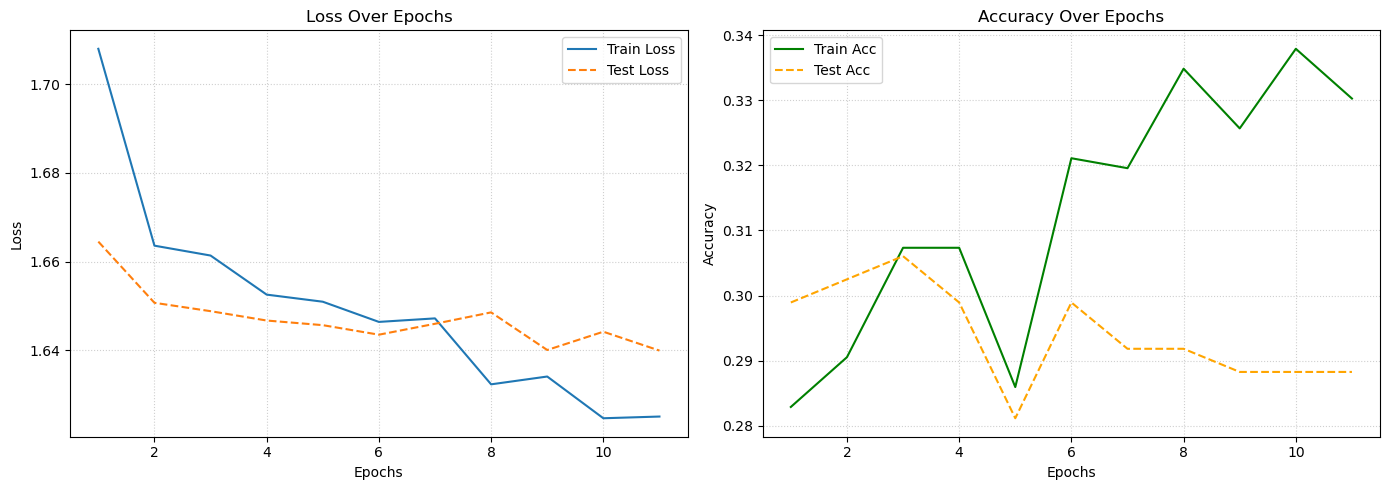

In [146]:
def plot_history(history):
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # --- PLOT LOSS ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['test_loss'], label='Test Loss', linestyle='--')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    
    # --- PLOT ACCURACY ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Train Acc', color='green')
    plt.plot(epochs_range, history['test_acc'], label='Test Acc', linestyle='--', color='orange')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# Run the plotter
plot_history(history)


📊 Evaluating on Test Set...

Classification Report:
                 precision    recall  f1-score   support

 Bearish Normal       0.35      0.40      0.37        84
Bearish Pennant       0.60      0.14      0.23        21
  Bearish Wedge       0.15      0.22      0.18        32
 Bullish Normal       0.36      0.45      0.40        82
Bullish Pennant       0.07      0.03      0.05        30
  Bullish Wedge       0.14      0.06      0.09        32

       accuracy                           0.30       281
      macro avg       0.28      0.22      0.22       281
   weighted avg       0.29      0.30      0.28       281



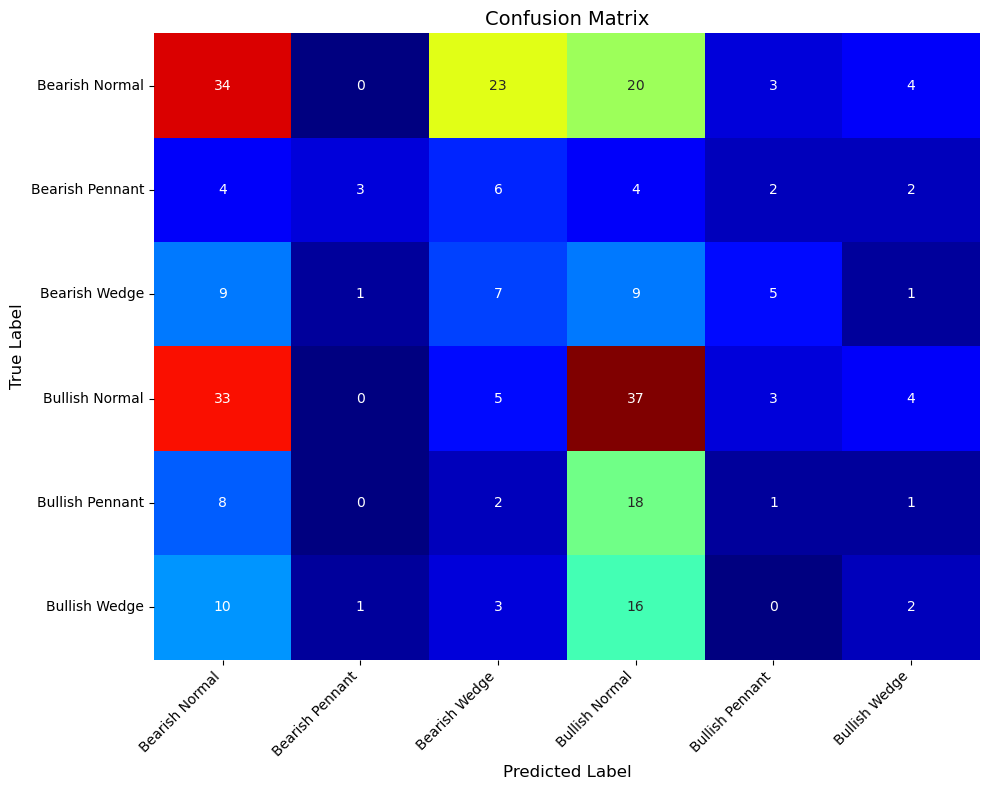

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- TEST ---
print("\n📊 Evaluating on Test Set...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch, lengths in test_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        
        output = model(X_batch, lengths)
        _, predicted = torch.max(output, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# --- PLOT CONFUSION MATRIX ---
# Calculate the matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.le.classes_))
class_names = train_dataset.le.classes_

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='jet', cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

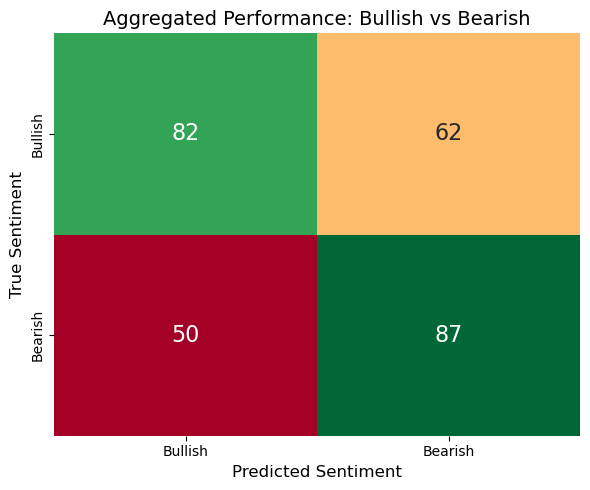

Binary Accuracy (Bull vs Bear): 60.1%


In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Map specific indices back to high-level categories (Bullish/Bearish)
# train_dataset.le.classes_ holds strings like ['Bearish Normal', 'Bullish Pennant'...]
idx_to_class = {i: name for i, name in enumerate(train_dataset.le.classes_)}

def get_sentiment(idx):
    name = idx_to_class[idx]
    if "Bullish" in name:
        return "Bullish"
    elif "Bearish" in name:
        return "Bearish"
    else:
        return "Unknown" # Should not happen

# 2. Convert your existing predictions/labels to these new categories
binary_labels = [get_sentiment(y) for y in all_labels]
binary_preds = [get_sentiment(p) for p in all_preds]

# 3. Create the 2x2 Confusion Matrix
labels_order = ["Bullish", "Bearish"]
cm_binary = confusion_matrix(binary_labels, binary_preds, labels=labels_order)

# 4. Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='RdYlGn', cbar=False,
            xticklabels=labels_order, yticklabels=labels_order, annot_kws={"size": 16})

plt.xlabel('Predicted Sentiment', fontsize=12)
plt.ylabel('True Sentiment', fontsize=12)
plt.title('Aggregated Performance: Bullish vs Bearish', fontsize=14)
plt.tight_layout()
plt.show()

correct = sum(1 for true, pred in zip(binary_labels, binary_preds) if true == pred)
print(f"Binary Accuracy (Bull vs Bear): {correct / len(binary_labels):.1%}")